In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True) 

In [6]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine) 

In [9]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Use Inspector to print the column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Use inspector to view station table columns
columns = inspector.get_columns('station')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Start Date: {first_date[0]} , End Date: {last_date[0]}")

Start Date: 2010-01-01 , End Date: 2017-08-23


In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_date_year = dt.date(2017,8,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > last_date_year).\
        order_by(Measurement.date).all()
precipitation[1]

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation, columns = ['Date', 'Precipitation']).dropna()
prcp_df.set_index("Date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(["Date"], ascending=True)
prcp_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15


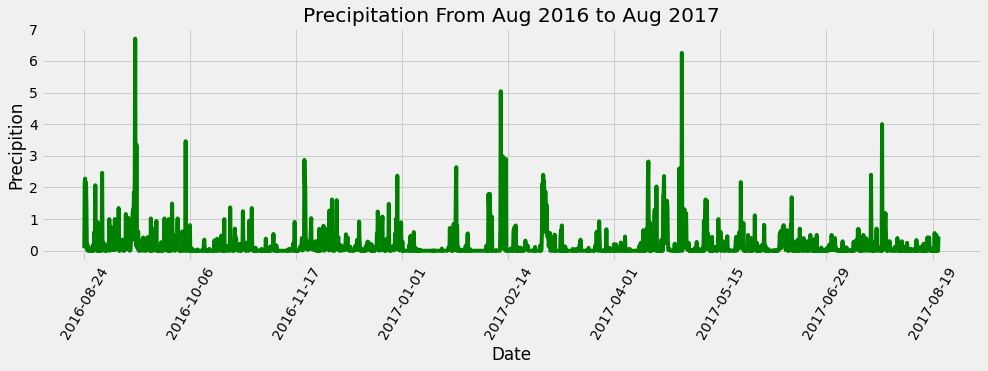

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot('Date', 'Precipitation', title = 'Precipitation From Aug 2016 to Aug 2017', 
             legend=False, figsize=(15, 4), color = 'green')
plt.xlabel('Date')
plt.ylabel('Precipition')
plt.xticks(rotation = 60);
plt.savefig("Resources/Precipitation.png")

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count() 
print(f" Total Number of Stations: {total_stations}")

 Total Number of Stations: 9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
for station, observations in active_stations:
    print(f" Station {station} had {observations} observations")

 Station USC00519281 had 2772 observations
 Station USC00519397 had 2724 observations
 Station USC00513117 had 2709 observations
 Station USC00519523 had 2669 observations
 Station USC00516128 had 2612 observations
 Station USC00514830 had 2202 observations
 Station USC00511918 had 1979 observations
 Station USC00517948 had 1372 observations
 Station USC00518838 had 511 observations


In [21]:
# Find most active station
most_active = active_stations[0][0]
print(f" Most active station: {most_active}")

 Most active station: USC00519281


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]
temp_data = session.query(*sel).\
    group_by(Measurement.station).\
    filter(Measurement.station == most_active).all()
temp_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= last_date_year).order_by(Measurement.date).all()
temperatures = pd.DataFrame(temps, columns = ['Station', 'Date', 'Tobs']).dropna()
temperatures

,Station,Date,Tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
...,...,...,...
347,USC00519281,2017-08-14,77.0
348,USC00519281,2017-08-15,77.0
349,USC00519281,2017-08-16,76.0
350,USC00519281,2017-08-17,76.0


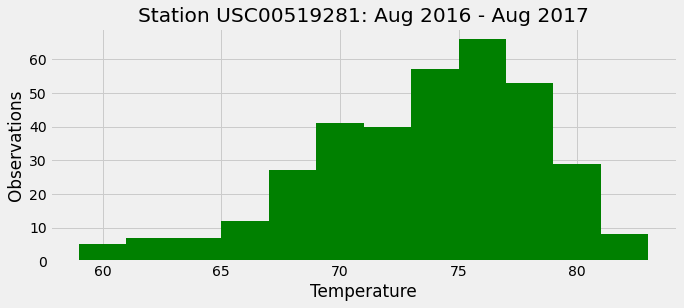

In [24]:
# plot the results as a histogram
temperatures.plot.hist(bins = 12, legend=False, figsize=(10, 4), color = 'green')
plt.title("Station USC00519281: Aug 2016 - Aug 2017")
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.savefig("Resources/Station.png")

# Close session

In [25]:
# Close Session
session.close()